# Chest X-Ray (Pneumonia): CNN Network 

Baseline CNN Network

We develop a CNN Network with four CNN layers structured in three blocks \
The dataset is split in three files, Train, Test and Validation \
The Validation dataset is too small, for this reason we modify the approach \
We use 80% of train for training \
20% of train for validation (training the network) \
We use the test dataset for Testing the network to obtain the final result \
\
Train accuracy 93.4%
Val accuracy 95%
Test accuracy 81%
ROC 93%

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------validation
#
main_path = "./chest_xray_data/"


train_path = os.path.join(main_path,"TRAIN")
test_path = os.path.join(main_path,"TEST")
val_path  = os.path.join(main_path,"VALIDATION")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                      columns = ['class'])
df_val['image'] = [x for x in val_list]

train_df = df_train
test_df = df_test
val_df = df_val

### Data Preparation
The validation set has too few images, we change the structure of the datasets, we will use 80% of df_train for training, 20% of df_training for validation and df_test to verify the final result

Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [6]:
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',df_test.shape)
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

shapes. Train:  (4099, 2) val :  (878, 2) test :  (878, 2)
Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.


In [7]:
import itertools
one_item = list(itertools.islice(ds_test,1))
a = one_item[0]
print('Shape of one element of the iterator', a[0].shape, a[1].shape)

Shape of one element of the iterator (1, 224, 224, 3) (1,)


### CNN
Data is ready. Now we define the CNN network and train 

In [8]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

In [9]:
def get_model():
    
    # CNN Layers
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # MLP - Classification layers
    
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [10]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00003), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
128/128 [==============================] - 181s 1s/step - loss: 0.5534 - binary_accuracy: 0.7438 - val_loss: 0.7349 - val_binary_accuracy: 0.7301 - lr: 3.0000e-05
Epoch 2/50
128/128 [==============================] - 180s 1s/step - loss: 0.4026 - binary_accuracy: 0.8148 - val_loss: 1.2181 - val_binary_accuracy: 0.7301 - lr: 3.0000e-05
Epoch 3/50
129/128 [==============================] - ETA: -1s - loss: 0.3226 - binary_accuracy: 0.8524
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
128/128 [==============================] - 180s 1s/step - loss: 0.3226 - binary_accuracy: 0.8524 - val_loss: 1.5526 - val_binary_accuracy: 0.7301 - lr: 3.0000e-05
Epoch 4/50
 97/128 [=====================>........] - ETA: 42s - loss: 0.2778 - binary_accuracy: 0.8777

## Measuring the accuracy of the CNN Network

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Confusion Matrix and ROC Curve

In [17]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [18]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [19]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8076923076923077


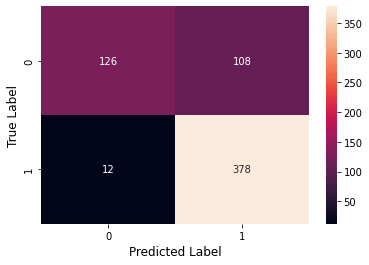

In [20]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [21]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.91      0.54      0.68       234
           1       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



ROC_AUC:  0.9346592154284462


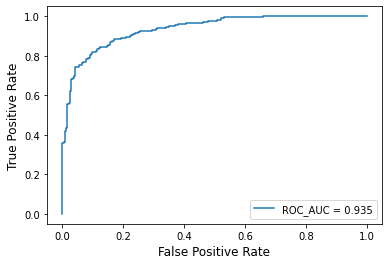

In [22]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

# <a id="9">References</a> 

- https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
- https://www.tensorflow.org/guide/keras/transfer_learning
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/applications/
- https://keras.io/api/applications/resnet/#resnet152v2-function